In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
gdf = gpd.read_file('https://gis.data.ca.gov/api/download/v1/items/900992cc94ab49dbbb906d8f147c2a72/shapefile?layers=0')

In [4]:
import pygris

In [174]:
state_shapes = pygris.states(cache=True)
county_shapes = pygris.counties(state='CA', cache=True)

Using the default year of 2024
Using the default year of 2024
HTTP download failed, trying FTP as fallback...
Using FIPS code '06' for input 'CA'


In [13]:
california = state_shapes[state_shapes['GEOID'] == '06']

In [ ]:
target_crs = california.crs
gdf.crs = target_crs

In [32]:
gdf_ca = gdf.sjoin(california, how='inner', predicate='within')

## Point Data

<Axes: >

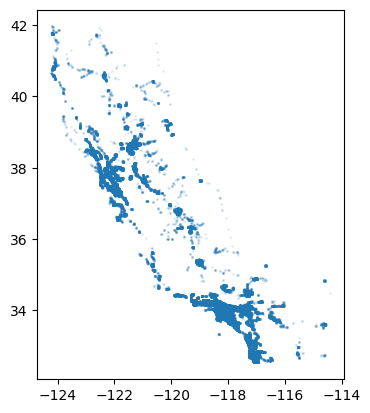

In [196]:
gdf_ca.plot(markersize=1, alpha=.1)

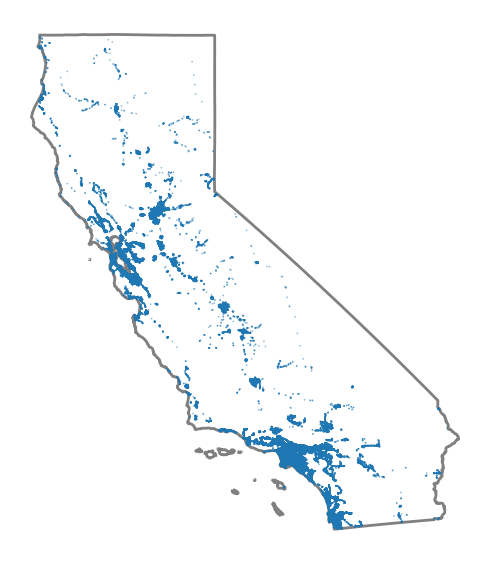

In [198]:
fig, ax = plt.subplots(figsize=(5, 10))
california.plot(ax = ax, edgecolor='grey', facecolor="none", linewidth=2, zorder=-1)
gdf_ca.plot(ax = ax, markersize=1.5, alpha=.5, edgecolor='none', linewidth=.05)
ax.axis('off')
fig.tight_layout()

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import box
import geopandas as gpd

def histogram_to_geodataframe(hist, x_edges, y_edges, crs=None):
    """
    Convert a 2D histogram and bin edges into a GeoDataFrame of grid cells with counts.

    Parameters:
    ----------
    hist : 2D numpy array
        The histogram values (as returned by geospatial_histogram, already transposed).
    x_edges : 1D numpy array
        Bin edges along the x-axis.
    y_edges : 1D numpy array
        Bin edges along the y-axis.
    crs : any (optional)
        Coordinate reference system for the GeoDataFrame.

    Returns:
    -------
    gdf : GeoDataFrame
        A GeoDataFrame with one polygon per grid cell, with a 'count' column.
    """
    rows, cols = hist.shape
    polygons = []
    counts = []

    for i in range(rows):
        for j in range(cols):
            count = hist[i, j]
            if count == 0:
                continue  # Skip empty cells for efficiency
            x0 = x_edges[j]
            x1 = x_edges[j + 1]
            y0 = y_edges[i]
            y1 = y_edges[i + 1]
            polygons.append(box(x0, y0, x1, y1))
            counts.append(count)

    gdf = gpd.GeoDataFrame({'count': counts, 'geometry': polygons}, crs=crs)
    return gdf


def geospatial_histogram(gdf, cell_size, bounds=None):
    """
    Create a 2D geospatial histogram (raster grid of counts) from a GeoDataFrame of points.
    
    Parameters:
    ----------
    gdf : GeoDataFrame
        Must contain Point geometries in a projected CRS (e.g. meters).
    cell_size : float
        Width and height of grid cells (in CRS units, e.g. meters).
    bounds : tuple or None
        Optional (minx, miny, maxx, maxy). If None, computed from gdf.bounds.
        
    Returns:
    -------
    hist : 2D numpy array
        Histogram counts of points per grid cell.
    (Optional) x_edges, y_edges : 1D numpy arrays
        Bin edges in x and y directions.
    """
    if gdf.empty:
        raise ValueError("Input GeoDataFrame is empty.")
    if not gdf.geometry.geom_type.isin(['Point']).all():
        raise ValueError("All geometries must be Points.")

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    if bounds is None:
        minx, miny, maxx, maxy = gdf.total_bounds
    else:
        minx, miny, maxx, maxy = bounds
    # Define bin edges
    x_bins = np.arange(minx, maxx + cell_size, cell_size)
    y_bins = np.arange(miny, maxy + cell_size, cell_size)
    # Compute histogram
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=[x_bins, y_bins])
    # histogram2d returns shape (len(x_bins)-1, len(y_bins)-1) with axes (x, y)
    # Transpose so that rows = y, columns = x (like image/raster orientation)
    hist = hist.T
    return histogram_to_geodataframe(hist, x_edges, y_edges, crs=gdf.crs)


In [272]:
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches

In [273]:
cmap = mpl.colormaps.get_cmap('YlOrRd')
new_cmap = (
    colors
    .LinearSegmentedColormap
    .from_list('deep_reds',
               cmap(np.linspace(0.1, 1, 1000)))
               )

In [274]:
def thousands_formatter(x, pos):
    if x >= 1000:
        return f'{x/1000:.1f}k' if x % 1000 else f'{int(x/1000)}k'
    return f'{int(x)}'

In [275]:
legend_cbar_kws = {
    "format": FuncFormatter(thousands_formatter),
    "shrink": .8,
    "label": "Number of Public Transit Stops per 50K Sq. Meters",
    'location': 'bottom',
    'pad': 0.01
}

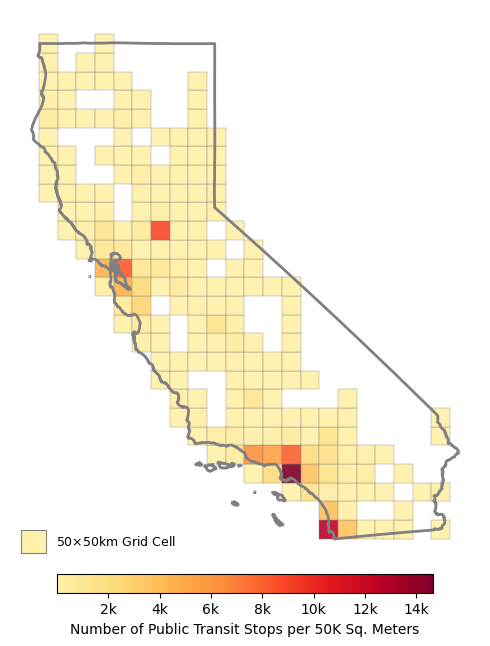

In [276]:
fig, ax = plt.subplots(figsize=(5, 10))
california.to_crs("EPSG:3857").plot(
    ax=ax, edgecolor="grey", facecolor="none", linewidth=2
)
geospatial_histogram(gdf_ca.to_crs("EPSG:3857"), 50000).fillna(0).plot(
    column="count",
    edgecolor="grey",
    linewidth=0.3,
    ax=ax,
    alpha=0.9,
    zorder=-1,
    cmap=new_cmap,
    legend=True,
    legend_kwds=legend_cbar_kws,
)

square_patch = mpatches.Rectangle(
    (0, 0), 10, 10,
    facecolor=new_cmap.get_under(),
    edgecolor="grey",
    linewidth=0.8
)
ax.legend(
    handles=[square_patch],
    labels=[r"50$\times$50km Grid Cell"],
    loc="lower left",
    frameon=False,
    fontsize=9,
    handlelength=2.0,
    handleheight=2.5,
)

ax.axis("off")
fig.tight_layout()

In [ ]:
# https://census.ca.gov/regions/
county_to_region = {
    "Butte": "Superior California",
    "Colusa": "Superior California",
    "El Dorado": "Superior California",
    "Glenn": "Superior California",
    "Lassen": "Superior California",
    "Modoc": "Superior California",
    "Nevada": "Superior California",
    "Placer": "Superior California",
    "Plumas": "Superior California",
    "Sacramento": "Superior California",
    "Shasta": "Superior California",
    "Sierra": "Superior California",
    "Siskiyou": "Superior California",
    "Sutter": "Superior California",
    "Tehama": "Superior California",
    "Yolo": "Superior California",
    "Yuba": "Superior California",
    "Del Norte": "North Coast",
    "Humboldt": "North Coast",
    "Lake": "North Coast",
    "Mendocino": "North Coast",
    "Napa": "North Coast",
    "Sonoma": "North Coast",
    "Trinity": "North Coast",
    "Alameda": "San Francisco Bay Area",
    "Contra Costa": "San Francisco Bay Area",
    "Marin": "San Francisco Bay Area",
    "San Francisco": "San Francisco Bay Area",
    "San Mateo": "San Francisco Bay Area",
    "Santa Clara": "San Francisco Bay Area",
    "Solano": "San Francisco Bay Area",
    "Alpine": "Northern San Joaquin Valley",
    "Amador": "Northern San Joaquin Valley",
    "Calaveras": "Northern San Joaquin Valley",
    "Madera": "Northern San Joaquin Valley",
    "Mariposa": "Northern San Joaquin Valley",
    "Merced": "Northern San Joaquin Valley",
    "Mono": "Northern San Joaquin Valley",
    "San Joaquin": "Northern San Joaquin Valley",
    "Stanislaus": "Northern San Joaquin Valley",
    "Tuolumne": "Northern San Joaquin Valley",
    "Monterey": "Central Coast",
    "San Benito": "Central Coast",
    "San Luis Obispo": "Central Coast",
    "Santa Barbara": "Central Coast",
    "Santa Cruz": "Central Coast",
    "Ventura": "Central Coast",
    "Fresno": "Southern San Joaquin Valley",
    "Inyo": "Southern San Joaquin Valley",
    "Kern": "Southern San Joaquin Valley",
    "Kings": "Southern San Joaquin Valley",
    "Tulare": "Southern San Joaquin Valley",
    "Riverside": "Inland Empire",
    "San Bernardino": "Inland Empire",
    "Los Angeles": "Los Angeles County",
    "Orange": "Orange County",
    "Imperial": "San Diego-Imperial",
    "San Diego": "San Diego-Imperial"
}


In [182]:
county_shapes['region'] = county_shapes['NAME'].map(county_to_region)
regions = county_shapes.dissolve(by='region')

<Axes: >

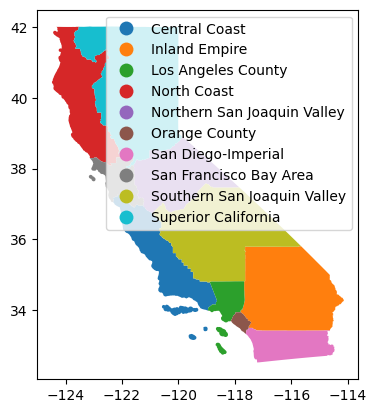

In [192]:
regions.reset_index().plot(column='region', legend=True)